In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# # set working directory
# import os
# os.chdir("//content/drive/My Drive/MIOTI/PRY/Emergencias/")

# # Check current working directory.
# retval = os.getcwd()
# print ("Current working directory %s" % retval)

<img src=".\img\mioti.png">   
<br />
<center style="color:#888">Proyecto Activaciones Madrid SAMUR-PC<br/></center>

# Proyecto Activaciones Madrid SAMUR-PC: Visualizaciones 

<img src="./img/samur690.jpg" style="width: 800px">

# Visión general del problema

* El objetivo de esta parte es gráficar los datos recopilados de estos 4 años de activaciones de emergencias de SAMUR-PC en los 21 distritos de Madrid y poder observar como se han comportado las activaciones por emergencias durante estos años y desgranadolas por distrito, tipología de activación y hospital para aquellas que al final necesitaron hospitalización. 

* A su vez, aprovechando que se disponen de datos gesoespaciales de las areas de los 21 distritos de Madrid se realizan 2 mapas con la situación hasta el momento y otro con la predición realizada con el modelo que propone Prophet las de 2022.

# Importación y preparación del entorno

In [3]:
# !pip install geopandas
# !pip install geoplot
# !pip install folium
# !pip install shapely
# !pip install contextily
# !pip install pyproj

# Para evitar el error RuntimeError: b'no arguments in initialization list' cuando folium trabaja con geopandas
# !pip install pyproj --upgrade 
# !pip install geopandas --upgrade

  Attempting uninstall: pyproj
    Found existing installation: pyproj 2.4.2.post1
    Uninstalling pyproj-2.4.2.post1:
      Successfully uninstalled pyproj-2.4.2.post1


ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\Usuario\\anaconda3\\Lib\\site-packages\\~yproj\\_crs.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.6.1
    Uninstalling geopandas-0.6.1:
      Successfully uninstalled geopandas-0.6.1


In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 10)
rcParams.update({'font.size': 14})
from pathlib import Path
#import geopandas as gpd
from shapely.geometry import Point
import seaborn as sb
import folium
import geopandas as gpd



# Obtención de los datos

In [5]:
#Cargamos el dataframe preprocesado de las activaciones de las emergencias Madrid
emergencias_df_aux=pd.read_csv('./datos/emergencias_pp_def.csv',sep=';', encoding='iso8859').reset_index(drop=True)
emergencias_df_aux.head()

,Fecha Activacion,Hora Solicitud,Hora Intervención,Código,Distrito,Hospital
0,2017-01-01,0:23:19,0:28:59,Heridas,Centro,Concepción (Fund. J. Díaz)
1,2017-01-01,0:27:35,0:35:44,Agresión sin especificar,Carabanchel,Sin hospitalizacion
2,2017-01-01,0:47:26,0:55:49,Intoxicación etílica,Salamanca,Sin hospitalizacion
3,2017-01-01,0:55:13,1:02:23,Agresión sin especificar,Centro,Doce de Octubre
4,2017-01-01,1:07:11,1:19:44,Accidente menos de 3 victimas,Villa de Vallecas,Sin hospitalizacion


In [6]:
emergencias_df_aux['Fecha Activacion']=pd.to_datetime(emergencias_df_aux['Fecha Activacion'])

In [7]:
emergencias_df_aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556526 entries, 0 to 556525
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Fecha Activacion   556526 non-null  datetime64[ns]
 1   Hora Solicitud     556526 non-null  object        
 2   Hora Intervención  508648 non-null  object        
 3   Código             556374 non-null  object        
 4   Distrito           556526 non-null  object        
 5   Hospital           556526 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 25.5+ MB


In [8]:
# Se carga el geojson de distritos de Madrid, que contiene las areas de cada distrito para poder representarlo
# en un mapa. Se ha otenido de la web https://team.carto.com/u/jsanz/tables/distritos/public

fichero='./datos/distritos.geojson'
map_munic_cam = gpd.read_file(fichero)
map_munic_cam.sample(5)

,nombre,coddistrit,shape_area,shape_len,cartodb_id,created_at,updated_at,geometry
19,San Blas - Canillejas,20,2.237017e+07,26698.903704,20,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.59329 40.45005, -3.59325 40..."
10,Chamberí,7,4.674107e+06,9020.565056,7,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.69122 40.44619, -3.69179 40..."
8,Tetuán,6,5.388122e+06,9925.073151,6,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.69764 40.47454, -3.69749 40..."
4,Barajas,21,4.190856e+07,28708.623102,21,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.56175 40.51116, -3.56167 40..."
1,Moncloa - Aravaca,9,4.653110e+07,41015.598541,9,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.80104 40.46945, -3.80018 40..."


In [9]:
map_munic_cam.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   nombre      21 non-null     object  
 1   coddistrit  21 non-null     object  
 2   shape_area  21 non-null     float64 
 3   shape_len   21 non-null     float64 
 4   cartodb_id  21 non-null     int64   
 5   created_at  21 non-null     object  
 6   updated_at  21 non-null     object  
 7   geometry    21 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 1.4+ KB


# Visualización

## Evolución de las emergencias de Madrid por Año

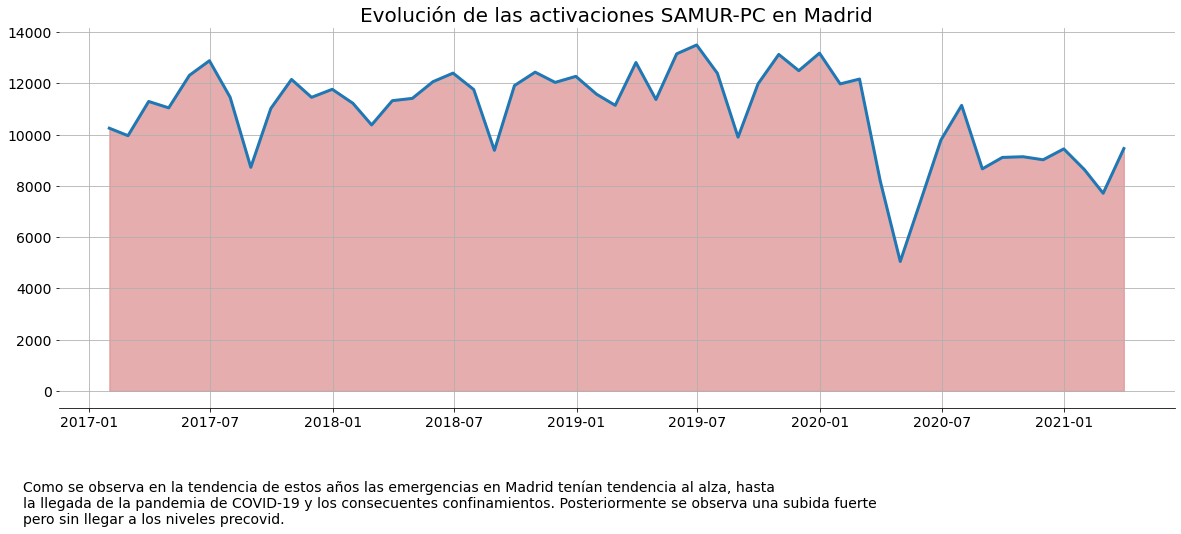

In [10]:
emergencias_df_ac=emergencias_df_aux.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac=emergencias_df_ac.resample('M').sum()
fig,ax=plt.subplots(figsize=(20,7))
ax.plot(emergencias_df_ac.index,emergencias_df_ac,linewidth=3)

# Sombreamos el área bajo la curva.
ax.fill_between(emergencias_df_ac.index, emergencias_df_ac.values.reshape(-1,), alpha=0.5,color='indianred')

# Mostramos la cuadricula.
ax.grid(True)#, axis='y')

## Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_title('Evolución de las activaciones SAMUR-PC en Madrid',fontsize=20)
caption = """Como se observa en la tendencia de estos años las emergencias en Madrid tenían tendencia al alza, hasta 
la llegada de la pandemia de COVID-19 y los consecuentes confinamientos. Posteriormente se observa una subida fuerte
pero sin llegar a los niveles precovid."""
fig.text(0.1, -0.1, caption, wrap=True,fontsize = 14);
# emergencias_df_ac

## Evolución comparativa de las emergencias de Madrid 4 ultimos años

In [11]:
emergencias_df_ac_2020_abril=emergencias_df_aux[(emergencias_df_aux['Fecha Activacion']>='2020-03')&(emergencias_df_aux['Fecha Activacion']<'2020-04')]
emergencias_df_ac_2020_abril=emergencias_df_ac_2020_abril.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac_2020_abril=emergencias_df_ac_2020_abril.resample('M').sum()
emergencias_df_ac_2020_abril['Numero_Mes']=emergencias_df_ac_2020_abril.index.month
emergencias_df_ac_2020_abril

emergencias_df_ac_2019_abril=emergencias_df_aux[(emergencias_df_aux['Fecha Activacion']>='2019-03')&(emergencias_df_aux['Fecha Activacion']<'2019-04')]
emergencias_df_ac_2019_abril=emergencias_df_ac_2019_abril.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac_2019_abril=emergencias_df_ac_2019_abril.resample('M').sum()
emergencias_df_ac_2019_abril['Numero_Mes']=emergencias_df_ac_2019_abril.index.month
emergencias_df_ac_2019_abril
emergencias_df_ac_abril=pd.concat((emergencias_df_ac_2019_abril,emergencias_df_ac_2020_abril))
emergencias_df_ac_abril['Incremento']=round(((emergencias_df_ac_abril['Código']/emergencias_df_ac_abril['Código'].shift(1))-1)*100,2)
emergencias_df_ac_abril=emergencias_df_ac_abril.rename(columns={'Código':'Activaciones'})
emergencias_df_ac_abril

,Activaciones,Numero_Mes,Incremento
Fecha Activacion,,,
2019-03-31,12810,3,NaN
2020-03-31,8194,3,-36.03


In [12]:
emergencias_df_ac_abril.iloc[1,0]

8194

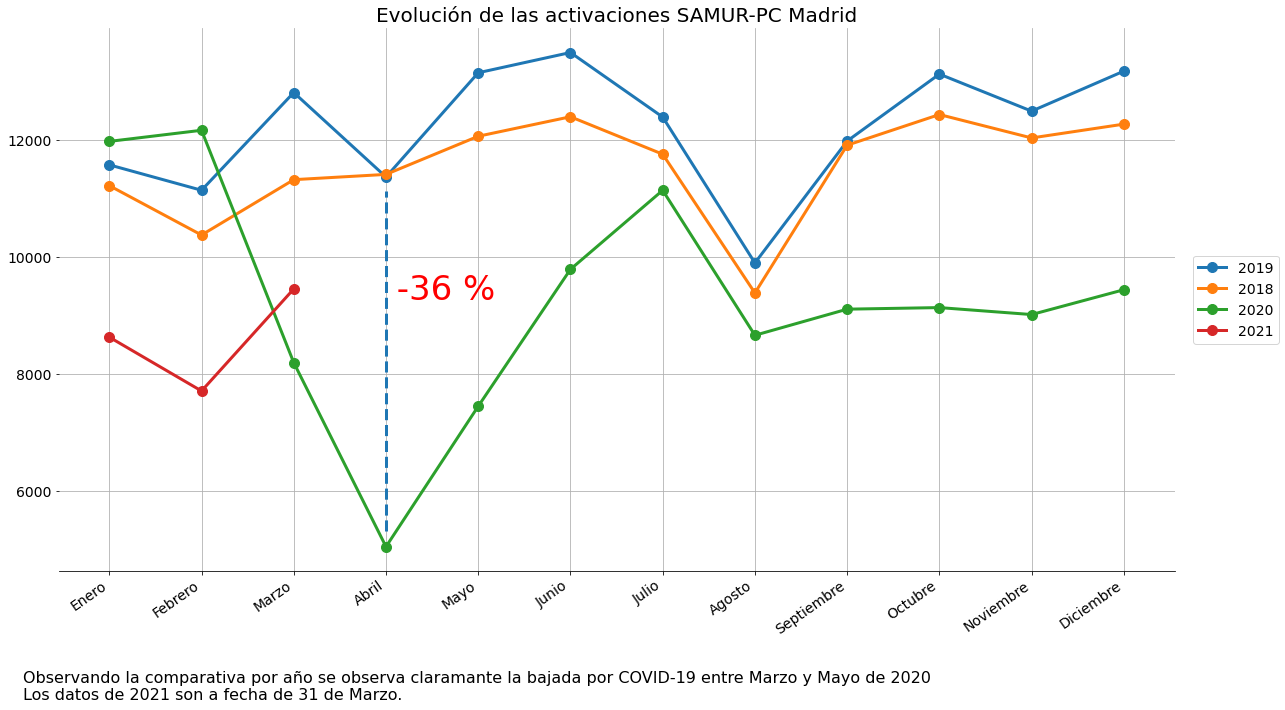

In [13]:
#GRAFICAMOS LAS EMERGENCIAS ATENDIDAs DURANTE EL AÑO 2020 vs 2019
emergencias_df_ac_2020=emergencias_df_aux[(emergencias_df_aux['Fecha Activacion']>='2020-01')&(emergencias_df_aux['Fecha Activacion']<'2021-01')]
emergencias_df_ac_2020=emergencias_df_ac_2020.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac_2020=emergencias_df_ac_2020.resample('M').sum()
emergencias_df_ac_2020['Numero_Mes']=emergencias_df_ac_2020.index.month
# emergencias_df_ac_2020

emergencias_df_ac_2019=emergencias_df_aux[(emergencias_df_aux['Fecha Activacion']>='2019-01')&(emergencias_df_aux['Fecha Activacion']<'2020-01')]
emergencias_df_ac_2019=emergencias_df_ac_2019.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac_2019=emergencias_df_ac_2019.resample('M').sum()
emergencias_df_ac_2019['Numero_Mes']=emergencias_df_ac_2019.index.month
# emergencias_df_ac_2019

emergencias_df_ac_2018=emergencias_df_aux[(emergencias_df_aux['Fecha Activacion']>='2018-01')&(emergencias_df_aux['Fecha Activacion']<'2019-01')]
emergencias_df_ac_2018=emergencias_df_ac_2018.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac_2018=emergencias_df_ac_2018.resample('M').sum()
emergencias_df_ac_2018['Numero_Mes']=emergencias_df_ac_2018.index.month
# emergencias_df_ac_2018

emergencias_df_ac_2021=emergencias_df_aux[(emergencias_df_aux['Fecha Activacion']>='2021-01')&(emergencias_df_aux['Fecha Activacion']<'2022-01')]
emergencias_df_ac_2021=emergencias_df_ac_2021.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac_2021=emergencias_df_ac_2021.resample('M').sum()
emergencias_df_ac_2021['Numero_Mes']=emergencias_df_ac_2021.index.month
# emergencias_df_ac_2021


fig,ax=plt.subplots()
ax.plot(emergencias_df_ac_2019['Numero_Mes'],emergencias_df_ac_2019['Código'],linewidth=3,label='2019',marker='o',markersize=10)
ax.plot(emergencias_df_ac_2018['Numero_Mes'],emergencias_df_ac_2018['Código'],linewidth=3,label='2018',marker='o',markersize=10)
ax.plot(emergencias_df_ac_2020['Numero_Mes'],emergencias_df_ac_2020['Código'],linewidth=3,label='2020',marker='o',markersize=10)
ax.plot(emergencias_df_ac_2021['Numero_Mes'],emergencias_df_ac_2021['Código'],linewidth=3,label='2021',marker='o',markersize=10)
ax.grid(True)

#Etiquetamos eje x con los meses en español%%bash
lista_meses=['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
ax.set_xticks(emergencias_df_ac_2019['Numero_Mes'])
ax.set_xticklabels(lista_meses,rotation=35, ha='right')

# plt.axvline(x=4,ymin=emergencias_df_ac_abril.iloc[1,0],ymax=emergencias_df_ac_abril.iloc[0,0],ls='--',lw=3)

plt.axvline(x=4,ymin=[0.075],ymax=[0.7],ls='--',lw=3)
ax.text(x=4,y=8500, s=" %d %% \n"%(emergencias_df_ac_abril.iloc[1,2]) ,color='red' ,ha='left', va='bottom' ,fontdict=dict(fontsize=34)) 
      


## Mostramos la cuadricula.
ax.grid(True, axis='y')

## Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)



ax.set_title('Evolución de las activaciones SAMUR-PC Madrid',fontsize = 20)
caption = """Observando la comparativa por año se observa claramante la bajada por COVID-19 entre Marzo y Mayo de 2020
Los datos de 2021 son a fecha de 31 de Marzo."""
ax.legend(loc='center left',bbox_to_anchor=(1.01, 0.5))
fig.text(0.1, -0.05, caption, wrap=True,fontsize = 16);
# emergencias_df_ac

In [14]:
#Calculamos las activaciones que se producen por año y sus incrementos porcentuales
emergencias_df_ac_year=emergencias_df_aux.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac_year=emergencias_df_ac_year.resample('Y').sum()
emergencias_df_ac_year['Anio']=emergencias_df_ac_year.index.year
emergencias_df_ac_year=emergencias_df_ac_year.rename(columns={'Código':'Activaciones'})
emergencias_df_ac_year['Incremento']=((emergencias_df_ac_year['Activaciones']/emergencias_df_ac_year['Activaciones'].shift(1))-1)*100
emergencias_df_ac_year

,Activaciones,Anio,Incremento
Fecha Activacion,,,
2017-12-31,134289,2017,NaN
2018-12-31,138574,2018,3.190879
2019-12-31,146596,2019,5.788965
2020-12-31,111121,2020,-24.199160
2021-12-31,25794,2021,-76.787466


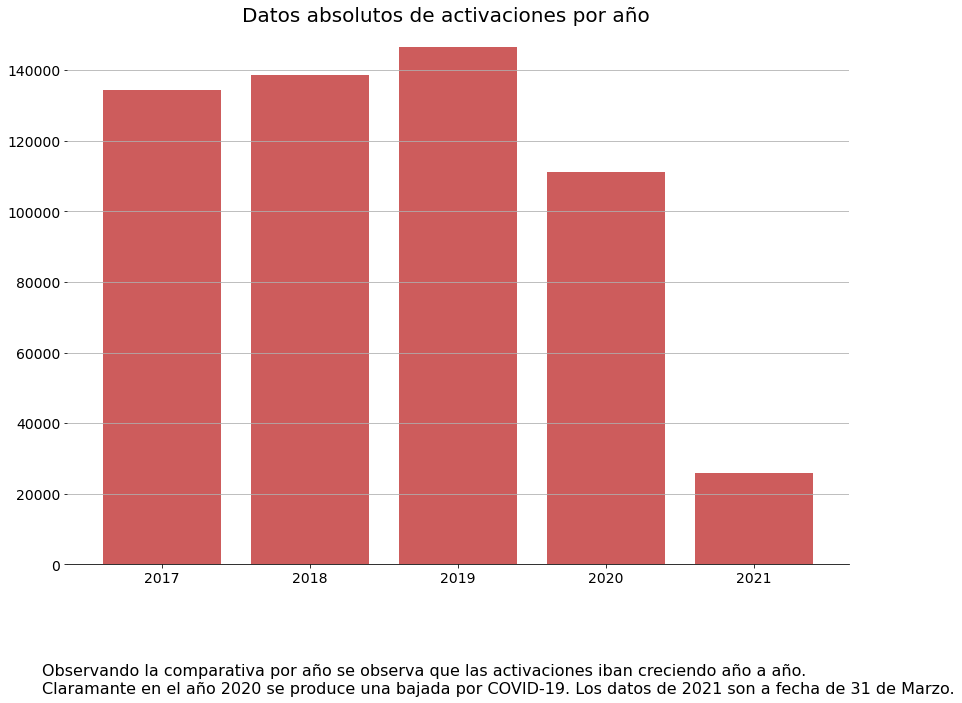

In [15]:
#GRAFICAMOS LAS EMERGENCIAS EM DATOS ABSOLUTOS
#Se grafica
fig,ax=plt.subplots(figsize=(14,10))
etiquetas_anio=emergencias_df_ac_year['Anio']


ax.bar(etiquetas_anio,emergencias_df_ac_year['Activaciones'],color='indianred')


# Mostramos la cuadricula.
ax.grid(True, axis='y')

# Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
caption = """Observando la comparativa por año se observa que las activaciones iban creciendo año a año.
Claramante en el año 2020 se produce una bajada por COVID-19. Los datos de 2021 son a fecha de 31 de Marzo."""
#ax.legend(loc='center left',bbox_to_anchor=(1.01, 0.5))

fig.suptitle('Datos absolutos de activaciones por año',y=.90,fontsize=20);
fig.text(0.1, -0.05, caption, wrap=True,fontsize = 16);


In [16]:
emergencias_df_ac_year_porcentaje=emergencias_df_ac_year[emergencias_df_ac_year['Anio']!=2021]

emergencias_df_ac_year_porcentaje


,Activaciones,Anio,Incremento
Fecha Activacion,,,
2017-12-31,134289,2017,NaN
2018-12-31,138574,2018,3.190879
2019-12-31,146596,2019,5.788965
2020-12-31,111121,2020,-24.199160


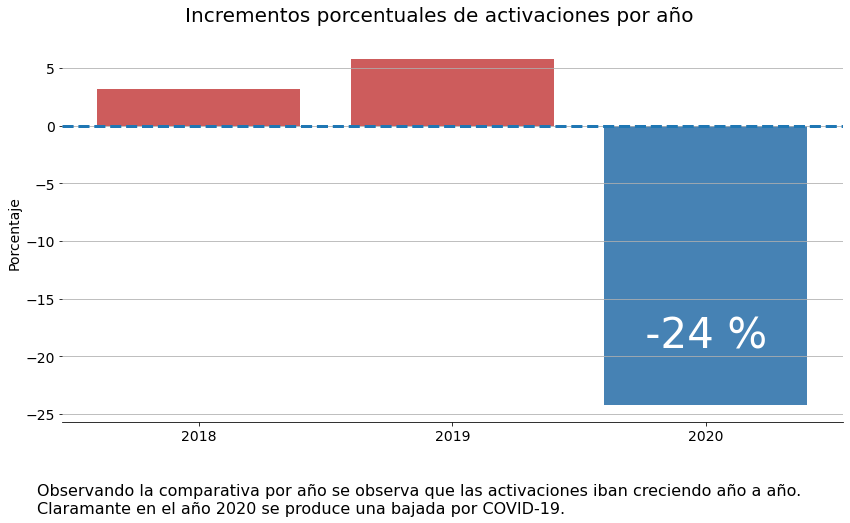

In [17]:
#GRAFICAMOS LAS EMERGENCIAS EM DATOS Relativos
#Se grafica
fig,ax=plt.subplots(figsize=(14,7))

# cantidad=emergencias_df_ac_year['Activaciones']
# porcentaje=emergencias_df_ac_year['Incremento']

# for index,data in enumerate(zip(etiquetas_anio,cantidad,porcentaje)):
    
#     if ((data[0]!=2017)&(data[0]!=2021)):
#         ax.text(x=data[0],y=data[1], s="%f \n"%(data[2]) , ha='center', va='bottom' ,fontdict=dict(fontsize=12))


emergencias_df_ac_year_porcentaje=emergencias_df_ac_year[emergencias_df_ac_year['Anio']!=2021]
etiquetas_anio=emergencias_df_ac_year_porcentaje['Anio'].astype(str)

emergencias_df_ac_year_porcentaje_pos=emergencias_df_ac_year_porcentaje[emergencias_df_ac_year_porcentaje['Incremento']>=0]
etiquetas_anio_pos=emergencias_df_ac_year_porcentaje_pos['Anio'].astype(str)

emergencias_df_ac_year_porcentaje_neg=emergencias_df_ac_year_porcentaje[emergencias_df_ac_year_porcentaje['Incremento']<0]
etiquetas_anio_neg=emergencias_df_ac_year_porcentaje_neg['Anio'].astype(str)

ax.bar(etiquetas_anio_pos,emergencias_df_ac_year_porcentaje_pos['Incremento'],color='indianred')
# ax.text(x=etiquetas_anio_neg,y=emergencias_df_ac_year_porcentaje_neg['Incremento'], s=" %d %% \n"%(emergencias_df_ac_year_porcentaje_neg['Incremento']) ,color='white' ,ha='center', va='bottom' ,fontdict=dict(fontsize=42)) 
ax.bar(etiquetas_anio_neg,emergencias_df_ac_year_porcentaje_neg['Incremento'],color='steelblue')
ax.text(x=etiquetas_anio_neg,y=emergencias_df_ac_year_porcentaje_neg['Incremento'], s=" %d %% \n"%(emergencias_df_ac_year_porcentaje_neg['Incremento']) ,color='white' ,ha='center', va='bottom' ,fontdict=dict(fontsize=42)) 

plt.axhline(y=0,ls='--',lw=3)
# Mostramos la cuadricula.
ax.grid(True, axis='y')
ax.set_ylabel('Porcentaje')
# Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
caption = """Observando la comparativa por año se observa que las activaciones iban creciendo año a año.
Claramante en el año 2020 se produce una bajada por COVID-19."""
#ax.legend(loc='center left',bbox_to_anchor=(1.01, 0.5))

fig.suptitle('Incrementos porcentuales de activaciones por año',y=.95,fontsize=20);
fig.text(0.1, -0.05, caption, wrap=True,fontsize = 16);


## Evolución comparativa de las emergencias de Madrid 4 ultimos años por semana

In [18]:
#Preparamos los datos para cada año
emergencias_df_ac_week_20=emergencias_df_aux[(emergencias_df_aux['Fecha Activacion']>='2020-01')&(emergencias_df_aux['Fecha Activacion']<'2021-01')]
emergencias_df_ac_week_20=emergencias_df_ac_week_20.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac_week_20=emergencias_df_ac_week_20.resample('D').sum()
emergencias_df_ac_week_20['Numero_Día']=emergencias_df_ac_week_20.index.dayofweek
emergencias_df_ac_week_20= emergencias_df_ac_week_20.groupby('Numero_Día',as_index=False).agg({'Código':'mean'})
# emergencias_df_ac_week_20

emergencias_df_ac_week_19=emergencias_df_aux[(emergencias_df_aux['Fecha Activacion']>='2019-01')&(emergencias_df_aux['Fecha Activacion']<'2020-01')]
emergencias_df_ac_week_19=emergencias_df_ac_week_19.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac_week_19=emergencias_df_ac_week_19.resample('D').sum()
emergencias_df_ac_week_19['Numero_Día']=emergencias_df_ac_week_19.index.dayofweek
emergencias_df_ac_week_19= emergencias_df_ac_week_19.groupby('Numero_Día',as_index=False).agg({'Código':'mean'})
# emergencias_df_ac_week_19

emergencias_df_ac_week_18=emergencias_df_aux[(emergencias_df_aux['Fecha Activacion']>='2018-01')&(emergencias_df_aux['Fecha Activacion']<'2019-01')]
emergencias_df_ac_week_18=emergencias_df_ac_week_18.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac_week_18=emergencias_df_ac_week_18.resample('D').sum()
emergencias_df_ac_week_18['Numero_Día']=emergencias_df_ac_week_18.index.dayofweek
emergencias_df_ac_week_18= emergencias_df_ac_week_18.groupby('Numero_Día',as_index=False).agg({'Código':'mean'})
# emergencias_df_ac_week_18

emergencias_df_ac_week_21=emergencias_df_aux[(emergencias_df_aux['Fecha Activacion']>='2021-01')&(emergencias_df_aux['Fecha Activacion']<'2022-01')]
emergencias_df_ac_week_21=emergencias_df_ac_week_21.groupby('Fecha Activacion').agg({'Código':'count'})
emergencias_df_ac_week_21=emergencias_df_ac_week_21.resample('D').sum()
emergencias_df_ac_week_21['Numero_Día']=emergencias_df_ac_week_21.index.dayofweek
emergencias_df_ac_week_21= emergencias_df_ac_week_21.groupby('Numero_Día',as_index=False).agg({'Código':'mean'})
# emergencias_df_ac_week_21



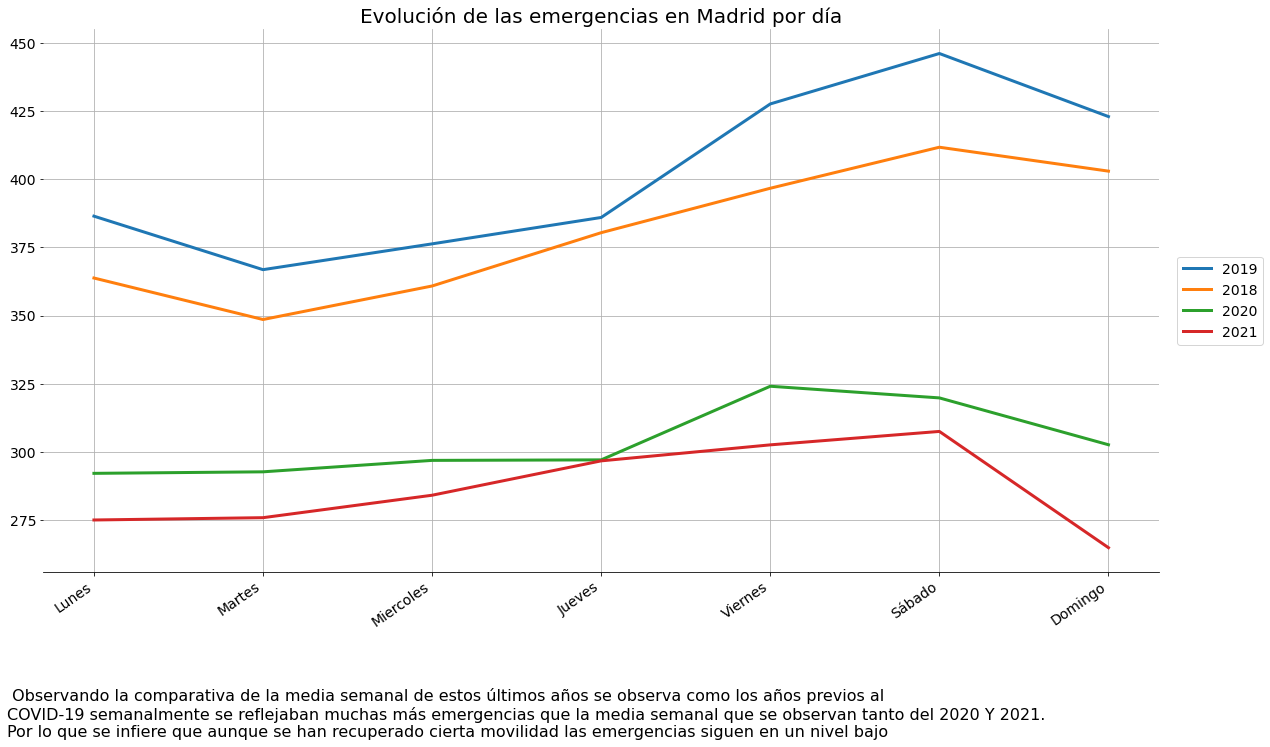

In [19]:
# Hacemos la visualización de los datos
fig,ax=plt.subplots(figsize=(20,10))
ax.plot(emergencias_df_ac_week_19['Numero_Día'],emergencias_df_ac_week_19['Código'],linewidth=3,label='2019')
ax.plot(emergencias_df_ac_week_18['Numero_Día'],emergencias_df_ac_week_18['Código'],linewidth=3,label='2018')
ax.plot(emergencias_df_ac_week_20['Numero_Día'],emergencias_df_ac_week_20['Código'],linewidth=3,label='2020')
ax.plot(emergencias_df_ac_week_21['Numero_Día'],emergencias_df_ac_week_21['Código'],linewidth=3,label='2021')

ax.grid(True)

#Etiquetamos eje x con los meses en español
lista_dias=['Lunes','Martes','Miercoles','Jueves','Viernes','Sábado','Domingo']
ax.set_xticks(emergencias_df_ac_week_20['Numero_Día'])
ax.set_xticklabels(lista_dias,rotation=35, ha='right')

## Mostramos la cuadricula.
ax.grid(True, axis='y')

## Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_title('Evolución de las emergencias en Madrid por día',fontsize=20)
caption = """ Observando la comparativa de la media semanal de estos últimos años se observa como los años previos al 
COVID-19 semanalmente se reflejaban muchas más emergencias que la media semanal que se observan tanto del 2020 Y 2021.
Por lo que se infiere que aunque se han recuperado cierta movilidad las emergencias siguen en un nivel bajo"""
# Añadimos la leyenda.    
ax.legend(loc='center left',bbox_to_anchor=(1.01, 0.5))
fig.text(0.1, -0.1, caption, wrap=True,fontsize=16);

## Evolución de las emergencias por tipología más comunes

In [20]:
#Consultamos la tipología de activaciones más importante
emergencias_df_aux['Código'].value_counts()

Casual: caída, etc                                               94733
Patología cardiovascular                                         91634
Intoxicación etílica                                             43584
Accidente menos de 3 victimas                                    28325
Agresión sin especificar                                         28126
                                                                 ...  
Persona sin techo fallecida en vía pública                         1
Atención psicológica a intervinientes de Bomberos.                   1
Acc. Trasp. Merc. Peligrosas                                         1
Atención psicológica a intervinientes de Cuerpos de Seguridad        1
No suceso                                                            1
Name: Código, Length: 94, dtype: int64

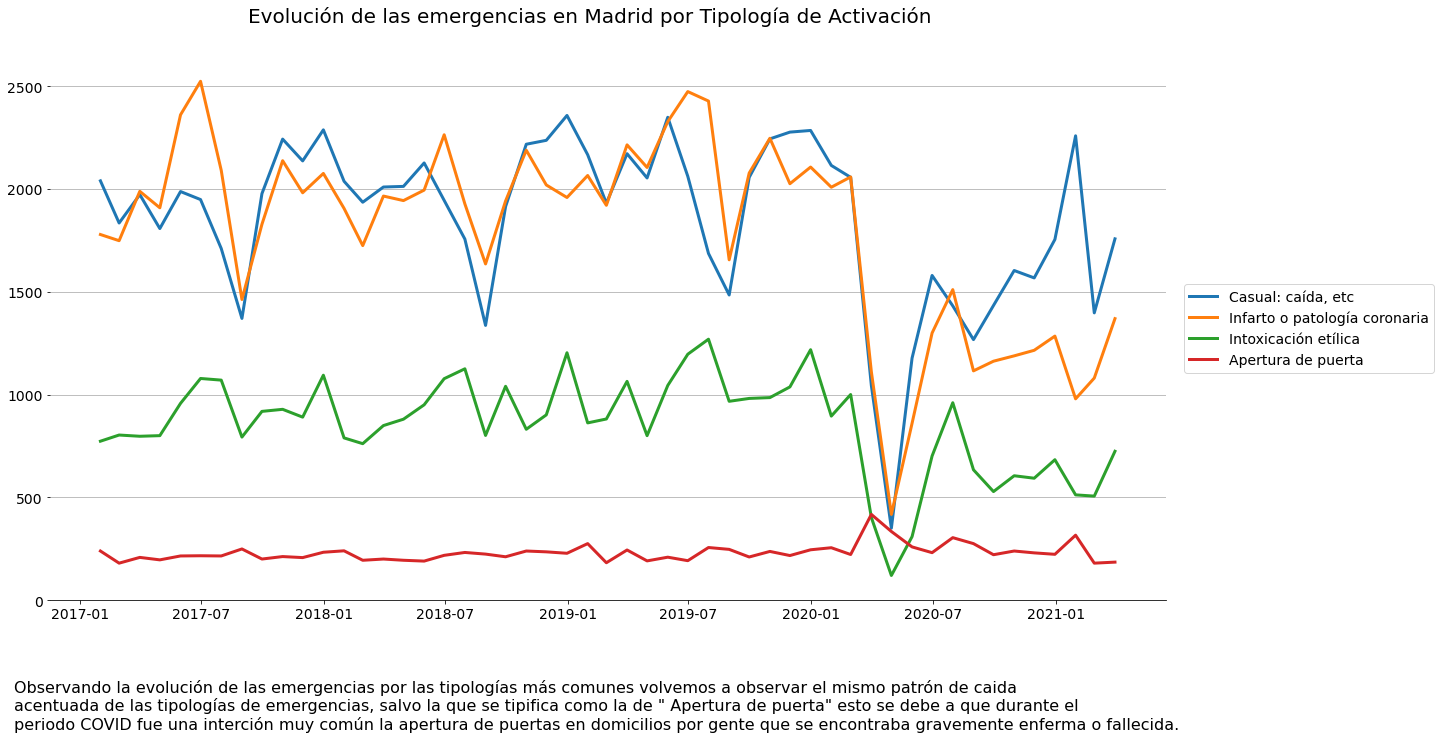

In [21]:
#Seleccionamos las 3 emergencias más comunes y la de "Apertura de puertas" por tener un comportamiento diferente en periodo
#COVID-19
emergencias_distritos_df=pd.pivot_table(emergencias_df_aux,index='Fecha Activacion',columns='Código',values='Distrito',aggfunc='count')
emergencias_distritos_df= emergencias_distritos_df.resample('M').sum()
emergencias_distritos_df

fig,ax=plt.subplots()
ax.plot(emergencias_distritos_df.index,emergencias_distritos_df['Casual: caída, etc'],linewidth=3,label='Casual: caída, etc')
ax.plot(emergencias_distritos_df.index,emergencias_distritos_df['Patología cardiovascular'],linewidth=3,label='Infarto o patología coronaria')
ax.plot(emergencias_distritos_df.index,emergencias_distritos_df['Intoxicación etílica'],linewidth=3,label='Intoxicación etílica')
ax.plot(emergencias_distritos_df.index,emergencias_distritos_df['Apertura de puerta'],linewidth=3,label='Apertura de puerta')

# Añadimos la leyenda.    
ax.legend(loc='right',bbox_to_anchor=(1.01, 0.5), title='Tipos de Activación')

## Mostramos la cuadricula.
ax.grid(True, axis='y')

## Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#Damos el título
fig.suptitle('Evolución de las emergencias en Madrid por Tipología de Activación', y=.95,fontsize=20)
# Añadimos la leyenda.    
ax.legend(loc='center left',bbox_to_anchor=(1.01, 0.5))


caption = """Observando la evolución de las emergencias por las tipologías más comunes volvemos a observar el mismo patrón de caida
acentuada de las tipologías de emergencias, salvo la que se tipifica como la de " Apertura de puerta" esto se debe a que durante el
periodo COVID fue una interción muy común la apertura de puertas en domicilios por gente que se encontraba gravemente enferma o fallecida."""
fig.text(0.1, -0.05, caption, wrap=True,fontsize=16);

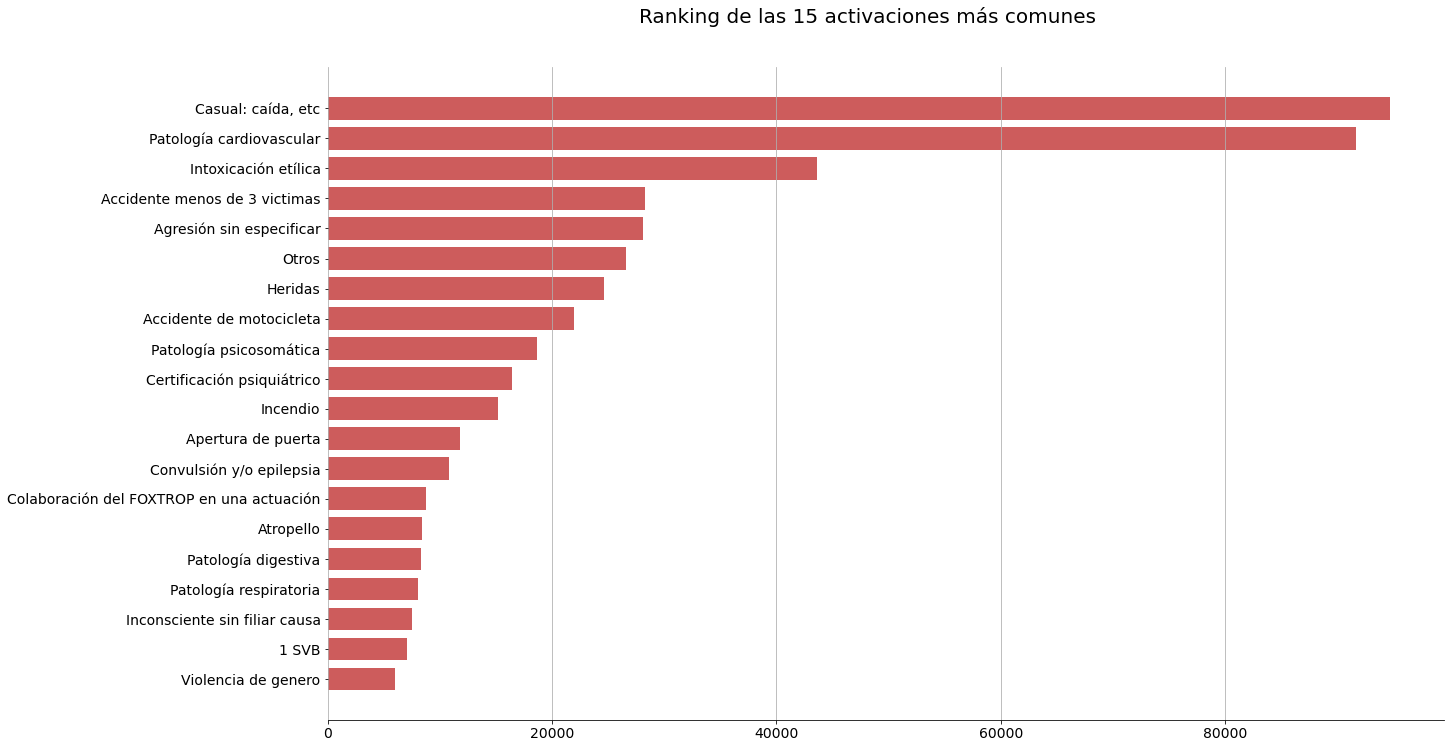

In [22]:
#ANALISIS DE LAS EMERGENCIAS
#Top 20 emergencias
emergencia=emergencias_df_aux.groupby('Código').agg({'Código':'count'})
emergencia=emergencia.rename(columns={'Código':'cuenta'})
emergencia=emergencia.sort_values(by='cuenta',ascending=True)
emergencia['fi']=emergencia['cuenta']
emergencia['Fi']=emergencia['fi'].cumsum()
emergencia=emergencia.tail(20)

#Se grafica

fig,ax=plt.subplots(figsize=(20,12))
etiquetas1=emergencia.index
ancho = 0.75
ax.barh(etiquetas1,emergencia['fi'],ancho,color='indianred')

# Etiquetamos el eje X.
# ax.set_ylabel('Distrito',fontsize=20)
# ax.set_xlabel('Número de activaciones',fontsize=20,labelpad=32)

# Mostramos la cuadricula.
ax.grid(True, axis='x')

# Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.suptitle('Ranking de las 15 activaciones más comunes',y=.95,fontsize=20);

## Evolución de las emergencias por Distritos

In [23]:
#Procedemos a realizar la extracción de datos para realizar un ranking por Distritos
emergencias_df_ranking_distritos=emergencias_df_aux.groupby(by='Distrito',as_index=False)['Código'].agg('count')
emergencias_df_ranking_distritos=emergencias_df_ranking_distritos.sort_values(by='Código',ascending=False)
emergencias_df_ranking_distritos.rename(columns={'Código': 'activaciones'}, inplace=True)
emergencias_df_ranking_distritos

,Distrito,activaciones
3,Centro,80492
2,Carabanchel,38471
12,Puente de Vallecas,34479
10,Moncloa - Aravaca,33984
9,Latina,32719
16,Tetuán,30928
14,Salamanca,30711
0,Arganzuela,29151
6,Ciudad Lineal,26126
5,Chamberí,26126


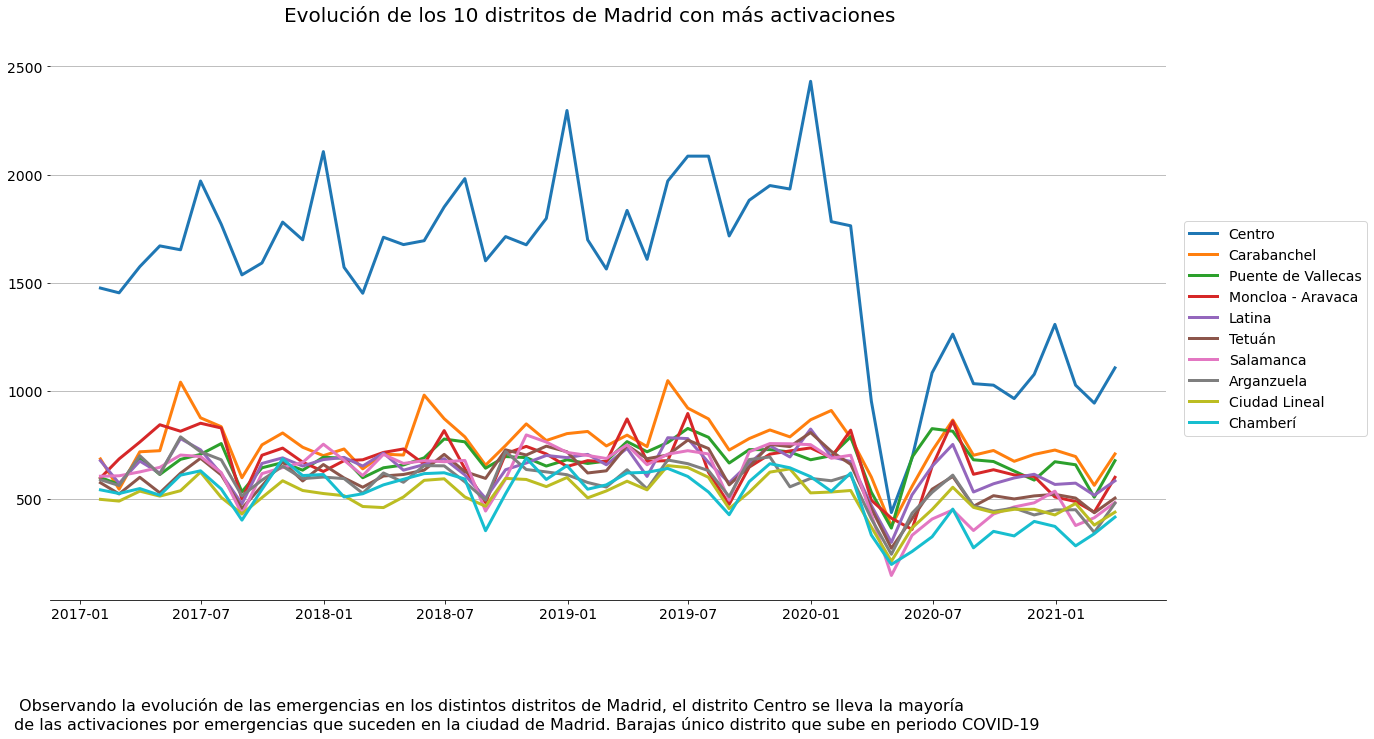

In [24]:
# Procedemos a visualizar los datos
emergencias_distritos_df=pd.pivot_table(emergencias_df_aux,index='Fecha Activacion',columns='Distrito',values='Código',aggfunc='count')
emergencias_distritos_df= emergencias_distritos_df.resample('M').sum()
distritos=emergencias_df_ranking_distritos['Distrito'][:10]

fig,ax=plt.subplots()
for distrito in distritos:
    ax.plot(emergencias_distritos_df.index,emergencias_distritos_df[distrito],linewidth=3,label=distrito)
   

# Mostramos la cuadricula.
ax.grid(True, axis='y')

# Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#Damos el título

titulo='Evolución de los '+ str(len(distritos)) +' distritos de Madrid con más activaciones'
fig.suptitle(titulo, y=.95,fontsize=20)
# Añadimos la leyenda.    
ax.legend(loc='center left',bbox_to_anchor=(1.01, 0.5))
caption = """ Observando la evolución de las emergencias en los distintos distritos de Madrid, el distrito Centro se lleva la mayoría
de las activaciones por emergencias que suceden en la ciudad de Madrid. Barajas único distrito que sube en periodo COVID-19"""
fig.text(0.1, -0.05, caption, wrap=True, fontsize=16);


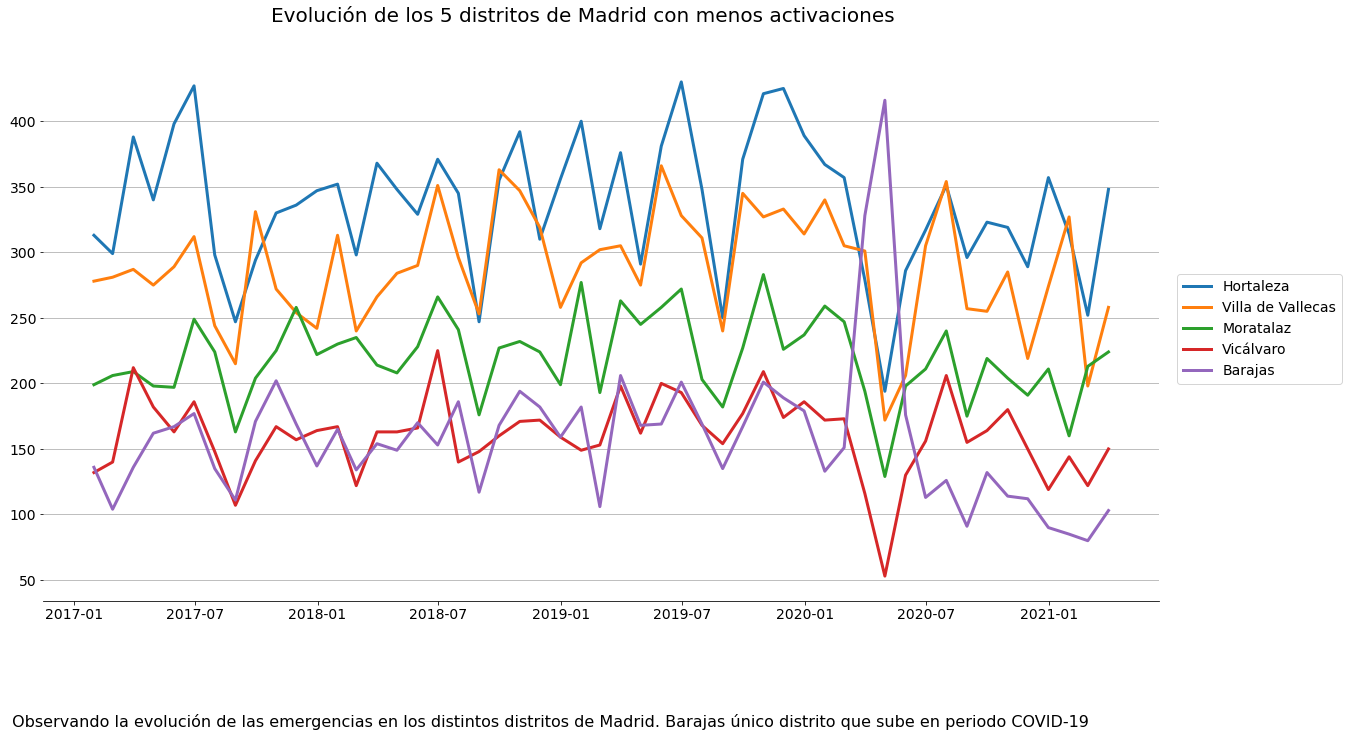

In [25]:
# Procedemos a visualizar los datos de los distritos con menor número activaciones
emergencias_distritos_df=pd.pivot_table(emergencias_df_aux,index='Fecha Activacion',columns='Distrito',values='Código',aggfunc='count')
emergencias_distritos_df= emergencias_distritos_df.resample('M').sum()
distritos=emergencias_df_ranking_distritos['Distrito'][-5:]

fig,ax=plt.subplots()
for distrito in distritos:
    ax.plot(emergencias_distritos_df.index,emergencias_distritos_df[distrito],linewidth=3,label=distrito)
   

# Mostramos la cuadricula.
ax.grid(True, axis='y')

# Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#Damos el título

titulo='Evolución de los '+ str(len(distritos)) +' distritos de Madrid con menos activaciones'
fig.suptitle(titulo, y=.95,fontsize=20)
# Añadimos la leyenda.    
ax.legend(loc='center left',bbox_to_anchor=(1.01, 0.5))
caption = """ Observando la evolución de las emergencias en los distintos distritos de Madrid. Barajas único distrito que sube en periodo COVID-19"""
fig.text(0.1, -0.05, caption, wrap=True, fontsize=16);


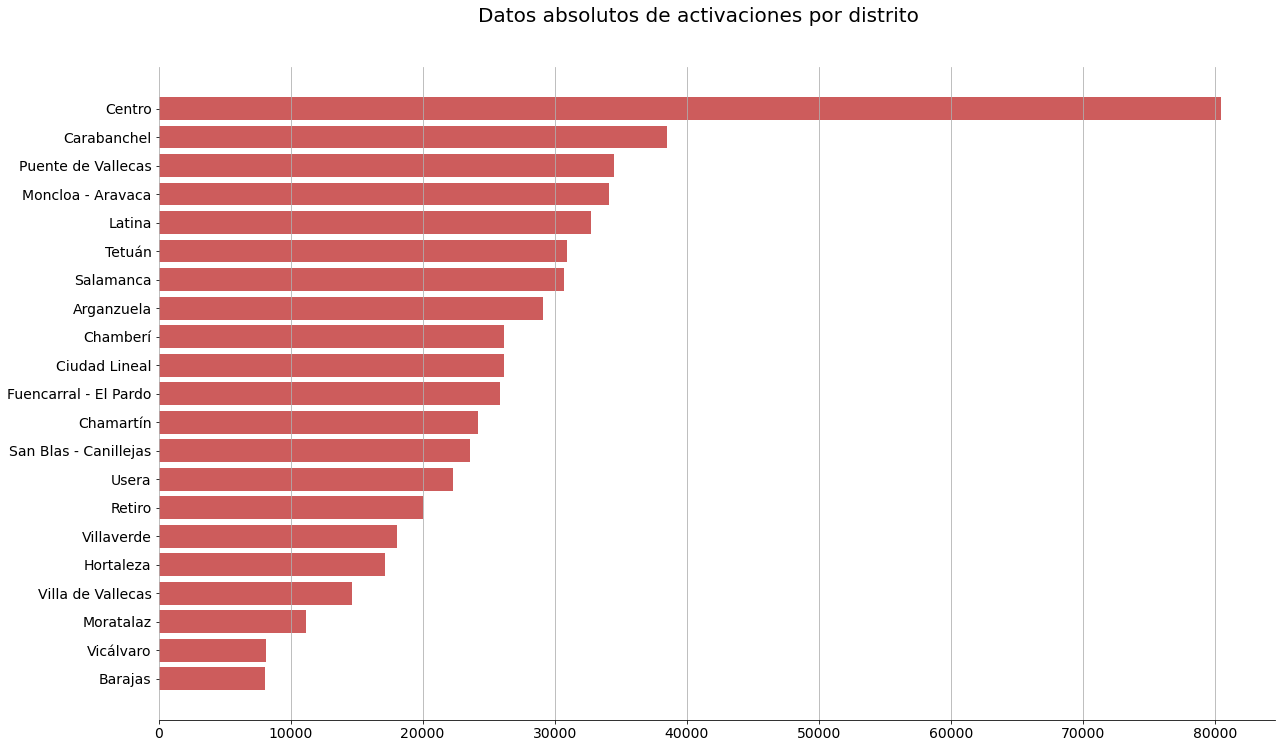

In [26]:
#ANALISIS DE LOS DISTRITOS
#Top 15 emrgencias
distrito=emergencias_df_aux.groupby('Distrito').agg({'Distrito':'count'})
distrito=distrito.rename(columns={'Distrito':'cuenta'})
distrito=distrito.sort_values(by='cuenta',ascending=True)
distrito['fi']=distrito['cuenta']
distrito['Fi']=distrito['fi'].cumsum()
distrito=distrito.tail(21)
#Se grafica
fig,ax=plt.subplots(figsize=(20,12))
etiquetas2=distrito.index

dist_ax=ax.barh(etiquetas2,distrito['fi'],color='indianred')

# Mostramos la cuadricula.
ax.grid(True, axis='x')

# Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.suptitle('Datos absolutos de activaciones por distrito',y=.95,fontsize=20);

## Evolución de las emergencias por Hospitales

In [27]:
#Se quitan los registros sin hospitalización
emergencias_hospitales_df=emergencias_df_aux[emergencias_df_aux['Hospital']!='Sin hospitalizacion']

emergencias_df_ranking_hospitales=emergencias_hospitales_df.groupby(by='Hospital',as_index=False)['Código'].agg('count')
emergencias_df_ranking_hospitales=emergencias_df_ranking_hospitales.sort_values(by='Código',ascending=False)
emergencias_df_ranking_hospitales.rename(columns={'Código': 'activaciones'}, inplace=True)
emergencias_df_ranking_hospitales

,Hospital,activaciones
9,Gregorio Marañón,28497
6,Doce de Octubre,26520
5,Concepción (Fund. J. Díaz),25919
11,La Paz,21444
4,Clínico San Carlos,20824
20,Ramón y Cajal,17890
12,La Princesa,14024
10,INFANTA LEONOR,10426
1,Central de la Defensa,7928
17,Niño Jesús (Infantil),1640


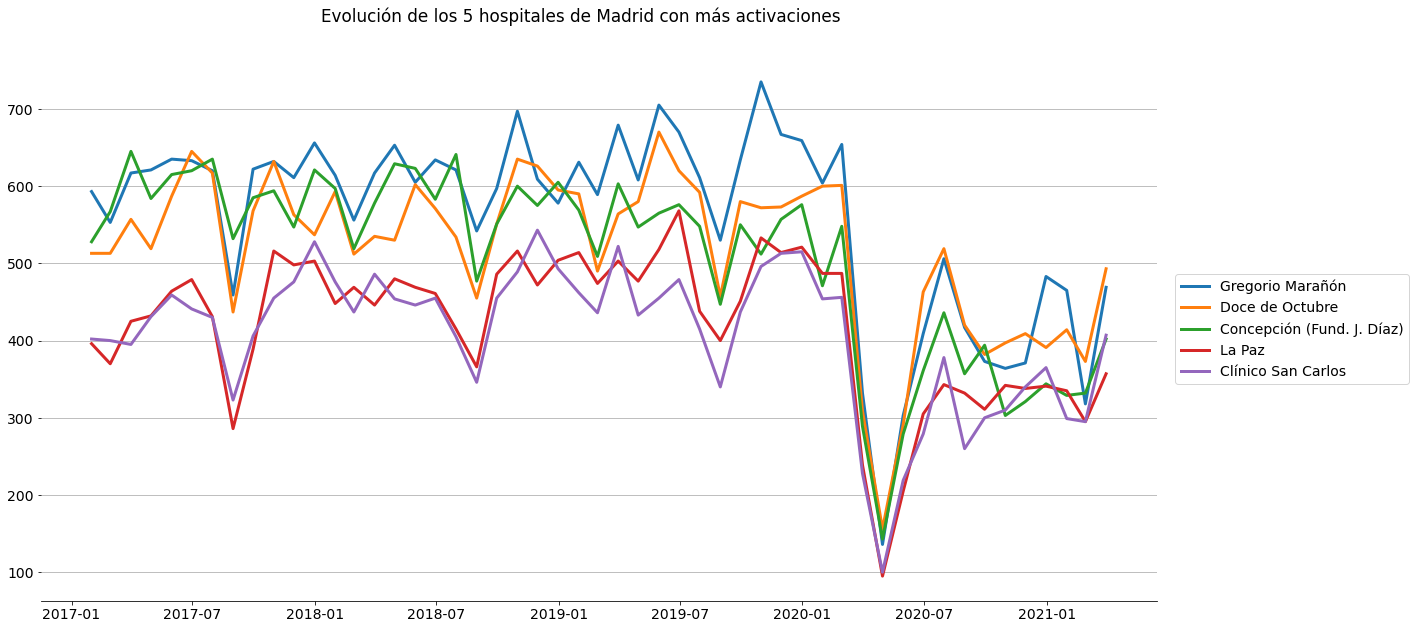

In [28]:
#Procedemos a visualizar los datos
emergencias_hospitales_df=pd.pivot_table(emergencias_hospitales_df,index='Fecha Activacion',columns='Hospital',values='Código',aggfunc='count')
emergencias_hospitales_df= emergencias_hospitales_df.resample('M').sum()
hospitales=emergencias_df_ranking_hospitales['Hospital'][:5]

fig,ax=plt.subplots()
for hospital in hospitales:
    ax.plot(emergencias_hospitales_df.index,emergencias_hospitales_df[hospital],linewidth=3,label=hospital)
   

# Mostramos la cuadricula.
ax.grid(True, axis='y')

# Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#Damos el título

titulo='Evolución de los '+ str(len(hospitales.index)) +' hospitales de Madrid con más activaciones'
fig.suptitle(titulo, y=.95)
# Añadimos la leyenda.    
ax.legend(loc='center left',bbox_to_anchor=(1.01, 0.5))
caption = ""
fig.text(0.1, -0.1, caption, wrap=True);

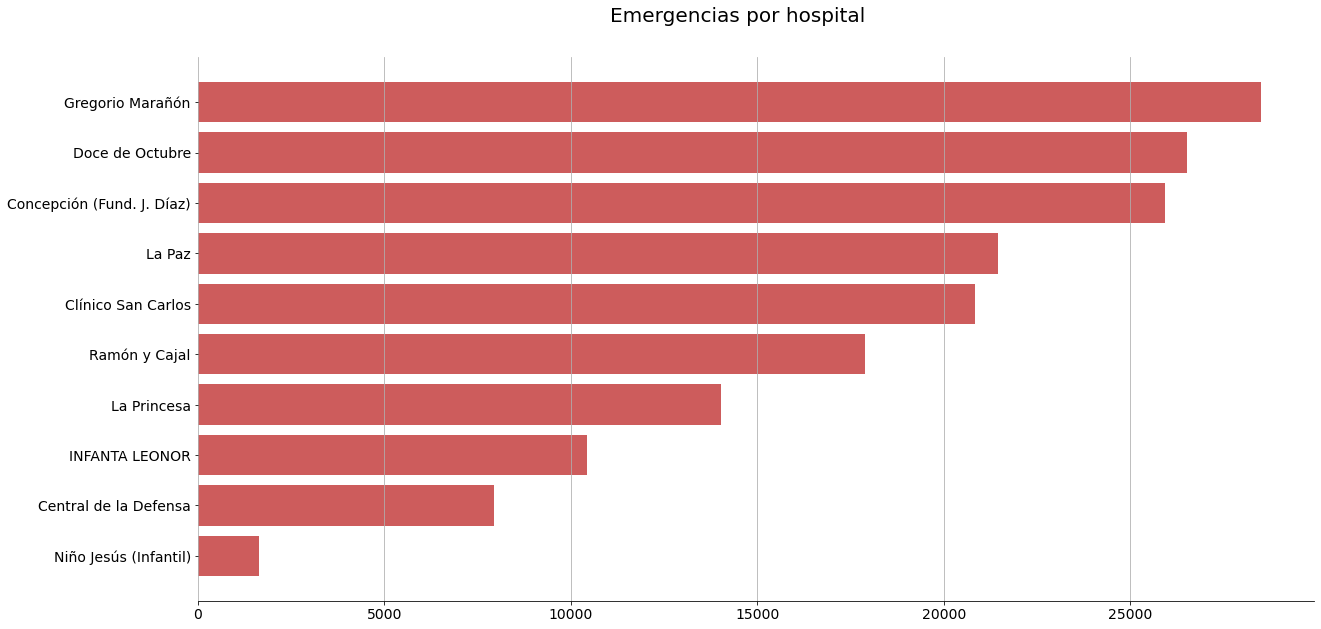

In [29]:
#ANALISIS DE LOS HOSPITALES
#Se quitan los registros sin hospitalización
hospital=emergencias_df_aux[emergencias_df_aux['Hospital']!='Sin hospitalizacion']

#Top 10 emrgencias
hospital=hospital.groupby('Hospital').agg({'Hospital':'count'})
hospital=hospital.rename(columns={'Hospital':'cuenta'})
hospital=hospital.sort_values(by='cuenta',ascending=True)
hospital['fi']=hospital['cuenta']
hospital['Fi']=hospital['fi'].cumsum()
hospital=hospital.tail(10)
#Se grafica
fig,ax=plt.subplots()
etiquetas3=hospital.index
hosp_ax=ax.barh(etiquetas3,hospital['fi'],color='indianred')
# Mostramos la cuadricula.
ax.grid(True, axis='x')

# Ocultamos el marco.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.suptitle('Emergencias por hospital',y=.95,fontsize=20);

## Mapas

### Mapa cloropeth de las emergencias en los distritos de Madrid

In [30]:
map_munic_cam

,nombre,coddistrit,shape_area,shape_len,cartodb_id,created_at,updated_at,geometry
0,Fuencarral - El Pardo,8,2.378101e+08,94525.156286,8,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.65282 40.64274, -3.65259 40..."
1,Moncloa - Aravaca,9,4.653110e+07,41015.598541,9,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.80104 40.46945, -3.80018 40..."
2,Villa de Vallecas,18,5.141792e+07,33553.533744,18,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.60761 40.38702, -3.60655 40..."
3,Vicálvaro,19,3.519385e+07,34157.734501,19,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.57764 40.41366, -3.57290 40..."
4,Barajas,21,4.190856e+07,28708.623102,21,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.56175 40.51116, -3.56167 40..."
5,Hortaleza,16,2.741467e+07,26944.593829,16,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.65245 40.51112, -3.65226 40..."
6,Retiro,3,5.465317e+06,9523.926778,3,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.66410 40.40852, -3.66515 40..."
7,Moratalaz,14,6.110086e+06,10824.413396,14,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.64289 40.41451, -3.64095 40..."
8,Tetuán,6,5.388122e+06,9925.073151,6,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.69764 40.47454, -3.69749 40..."
9,Centro,1,5.231267e+06,10304.545144,1,2015-07-06T13:59:20,2015-07-06T13:59:20,"MULTIPOLYGON (((-3.69316 40.40734, -3.69320 40..."


In [31]:
#Se consulta el ranking de hospitales con mas activaciones de emergencias
emergencias_df_ranking_distritos

,Distrito,activaciones
3,Centro,80492
2,Carabanchel,38471
12,Puente de Vallecas,34479
10,Moncloa - Aravaca,33984
9,Latina,32719
16,Tetuán,30928
14,Salamanca,30711
0,Arganzuela,29151
6,Ciudad Lineal,26126
5,Chamberí,26126


* Mapa cloropeth de llos distritos de Madrid y sus emergencias

In [32]:
#Hacemos merge con dataframe de geojson para relacionar areas con los datos de los dstritos y poder representarlos
emergencias_df_folium=pd.merge(emergencias_df_ranking_distritos,map_munic_cam,how='left',left_on='Distrito',right_on='nombre')
emergencias_df_folium=emergencias_df_folium[['nombre','activaciones','coddistrit','shape_area','shape_len','cartodb_id','created_at','updated_at','geometry']]
emergencias_df_folium['porcentaje']=round((emergencias_df_folium['activaciones']/emergencias_df_folium['activaciones'].sum())*100,2)

#El dataframe resultante lo convertimos en un geodataframe para poder trabajar de mejor forma.
emergencias_df_folium=gpd.GeoDataFrame(emergencias_df_folium,geometry='geometry')
emergencias_df_folium=emergencias_df_folium.dropna()
#emergencias_df_folium

In [33]:
#Hacemos las visualización en el mapa
MADRID_COORDS = [40.4567,  -3.70325]
m = folium.Map(MADRID_COORDS, zoom_start=10.5)


choropleth=folium.Choropleth(
    geo_data=map_munic_cam,
    data=emergencias_df_folium,
    fill_opacity=0.7,
    line_weight=2,
    fill_color='PuRd', line_opacity=0.2, # ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    columns=["nombre", "activaciones"],
    key_on='feature.properties.nombre',
    legend_name='Emergencias Madrid',
    highlight=True,
    # tooltip=folium.GeoJsonTooltip(
    #     fields=['nombre'],
    #     aliases=['nombre'],
    #     localize=True
    # ),
).add_to(m)

#folium.LayerControl().add_to(m)
# choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['nombre'], labels=False))

# Meter las labels a cada distrito 
geojson1 = folium.GeoJson(data=emergencias_df_folium,
           name='emergencias',
           smooth_factor=2,
           style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
           tooltip=folium.GeoJsonTooltip(fields=['nombre','activaciones','porcentaje'],
                                              aliases=['Distrito :','Nº Activaciones :','Porcentaje %:'],
                                              labels=True,
                                              sticky=True,
                                        localize=True
#                                         style= "font-size: 15px; font-weight: bold"
                                        ),
            highlight_function=lambda x: {'weight':3,'fillColor':'red'},
                      
                        
            ).add_to(choropleth)


m

### Mapa Predicción 2022 realizada con Prophet

In [34]:
#Cargamos el dataframe generado en predicción de las emergencias para 2022
emergencias_df_prediccion=pd.read_csv('./datos/prediccion_2022.csv',sep=';', encoding='iso8859').reset_index(drop=True)
emergencias_df_prediccion.sort_values('activaciones',ascending=False)

,Distritos,activaciones
0,Centro,36725
1,Carabanchel,11657
5,Puente de Vallecas,9808
4,Tetuán,9473
2,Salamanca,8884
6,Latina,8631
11,Moncloa - Aravaca,8360
17,Arganzuela,7293
10,Ciudad Lineal,7060
12,Chamberí,6848


In [35]:
#Calculamos la suma total
emergencias_df_prediccion['activaciones'].sum()

167856

In [36]:
#Hacemos merge con dataframe de geojson para relacionar areas con los datos de los dstritos y poder representarlos
emergencias_df_folium_pred=pd.merge(emergencias_df_prediccion,map_munic_cam,how='left',left_on='Distritos',right_on='nombre')
emergencias_df_folium_pred=emergencias_df_folium_pred[['nombre','activaciones','coddistrit','shape_area','shape_len','cartodb_id','created_at','updated_at','geometry']]
emergencias_df_folium_pred['porcentaje']=round((emergencias_df_folium_pred['activaciones']/emergencias_df_folium_pred['activaciones'].sum())*100,2)

#El dataframe resultante lo convertimos en un geodataframe para poder trabajar de mejor forma.
emergencias_df_folium_pred=gpd.GeoDataFrame(emergencias_df_folium_pred,geometry='geometry')
emergencias_df_folium_pred=emergencias_df_folium_pred.dropna()
#emergencias_df_folium

In [37]:
#Hacemos la visualización
MADRID_COORDS = [40.4567,  -3.70325]
m = folium.Map(MADRID_COORDS, zoom_start=10.5)


choropleth=folium.Choropleth(
    geo_data=map_munic_cam,
    data=emergencias_df_folium_pred,
    fill_opacity=0.7,
    line_weight=2,
    fill_color='PuRd', line_opacity=0.2, # ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    columns=["nombre", "activaciones"],
    key_on='feature.properties.nombre',
    legend_name='Emergencias Madrid',
    highlight=True,
 ).add_to(m)

# folium.LayerControl().add_to(m)
# choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['nombre'], labels=False))

# Meter las labels a cada distrito 
geojson1 = folium.GeoJson(data=emergencias_df_folium_pred,
           name='emergencias',
           smooth_factor=2,
           style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
           tooltip=folium.GeoJsonTooltip(fields=['nombre','activaciones','porcentaje'],
                                              aliases=['Distrito :','Nº Activaciones :','Porcentaje %:'],
                                              labels=True,
                                              sticky=True,
                                              localize=True
                                        ),
            highlight_function=lambda x: {'weight':3,'fillColor':'red'},
                        
            ).add_to(choropleth)
m